# Project Big Data for Finance

## 1. Choose a trading strategy and describe its rational 
The trading strategy chosen is a bottom-up pairs trading strategy applied to cryptocurrency trading pairs. This strategy involves identifying pairs of cryptocurrencies and executing trades based on the relative performance of those pairs. In the case of cryptocurrencies, the strategy will be implemented to identify pricing inefficiencies between individual coins or tokens and exploit them to make a profit.
This strategy is based on the rationale that different cryptocurrencies can have varying levels of performance due to factors such as technological advancements, market sentiment, regulatory developments, and overall market trends. It builds on the assumption that the prices of cryptocurrencies tend to move together over time, and deviations from this trend can be exploited for profit.
Below is a description of what we will do to implement this strategy:
1.	Get all the traded pairs listed in a CEX (in this case using the Binance API)
2.	Select the pair of cryptocurrencies within those pairs that display a pattern of high correlation in price movements over time.
3.	Calculate the spread of the difference between prices of the cryptocurrencies in the pair over time. 
4.	Determine threshold points for spread deviations that trigger an alert for an opportunity to exploit a mispricing. This will be defined through our trading rules to generate signals. 
5.	Execute trade when threshold is hit. 

An important note is that this strategy is based on the assumption that deviations from the trend are only temporary and that deviations should be corrected eventually after they occur. In the case that this strategy would be implemented on an ongoing basis, then after executing the trade we would need to continue monitoring the spread and define a target level for which we consider that the deviation has been corrected. 

## 2. Fetch data for a period greater than 5 years for the asset or assets you intend to test 

In [6]:
# %pip install backtrader
# %pip install yfinance
# %pip install statsmodels
# %pip install backtrader
# %pip install jinja2
# %pip install quantstats
# %pip install binance

In [7]:
import backtrader as bt
import numpy as np
import datetime
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import coint
import backtrader.indicators as btind
#from tqdm import tqdm
import time

In [8]:
# # Ran it once and saved the results to avoid leaving the API keys in this file (or attaching an .env file)

# from binance.spot import Spot as Client
# client = Spot('ZtoLGnP2f...',
#                'Dl2CEbw...')

# exchange_info = client.exchange_info()
# usdt = set()
# for s in exchange_info['symbols']:
#     if s['symbol'].endswith('USDT'):
#         usdt.add(s['symbol'][:-4])

# # open file in write mode
# with open(r'./allTickers.txt', 'w') as fp:
#     for item in usdt:
#         # write each item on a new line
#         formated_item = item+"-USD"
#         fp.write("%s\n" % formated_item)
#     print('Done')

In [9]:
#Reads the previously collected and saved list of listed token on binance
tickers = []
# open file and read the content in a list
with open(r'./allTickers.txt', 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]

        # add current item to the list
        tickers.append(x)

# display list
print(tickers)

['TOMO-USD', 'AAVE-USD', 'SXPDOWN-USD', 'XRPBULL-USD', 'SXP-USD', 'EPS-USD', 'MDX-USD', 'THETA-USD', 'CFX-USD', 'POWR-USD', 'ONT-USD', 'NEBL-USD', 'OP-USD', 'BCHABC-USD', 'XRP-USD', 'ZIL-USD', 'EOSBEAR-USD', 'ROSE-USD', 'FUN-USD', 'CELO-USD', 'COTI-USD', 'STRAT-USD', 'XTZUP-USD', 'BOND-USD', 'TCT-USD', 'BTCST-USD', 'ALPINE-USD', 'SYN-USD', 'UNI-USD', 'PLA-USD', 'TKO-USD', 'IDEX-USD', 'LUNC-USD', 'GLM-USD', 'XTZ-USD', 'DEXE-USD', 'LINKDOWN-USD', 'FET-USD', 'LINKUP-USD', 'PEOPLE-USD', 'BTCDOWN-USD', 'XEC-USD', 'ETH-USD', 'APE-USD', 'CAKE-USD', 'FIS-USD', 'EDU-USD', 'DAI-USD', 'BNBDOWN-USD', 'BCHUP-USD', 'AAVEUP-USD', 'KDA-USD', 'NANO-USD', 'VIB-USD', 'HC-USD', 'PYR-USD', 'JUV-USD', 'FTT-USD', 'BTS-USD', 'PSG-USD', 'HIVE-USD', 'JASMY-USD', 'TRU-USD', 'PHB-USD', 'YFI-USD', 'ANC-USD', 'WING-USD', 'MATIC-USD', 'DOGE-USD', 'AVAX-USD', 'MIR-USD', 'SSV-USD', 'BSW-USD', 'BTC-USD', 'TRXUP-USD', 'REI-USD', 'FIL-USD', 'IOST-USD', 'ETC-USD', 'C98-USD', 'DF-USD', 'TFUEL-USD', 'ORN-USD', 'PROM-USD', '

In [10]:
df = yf.download(tickers, start='2018-01-01')
df.sort_index(inplace=True)
df_forCointTest = df.Close.dropna(axis=1)
df.dropna(axis=1,inplace=True)

[                       1%                       ]  3 of 448 completed

[*********************100%***********************]  448 of 448 completed

23 Failed downloads:
- BTTC-USD: No timezone found, symbol may be delisted
- XLMDOWN-USD: No timezone found, symbol may be delisted
- GBP-USD: No timezone found, symbol may be delisted
- EOSUP-USD: No timezone found, symbol may be delisted
- IOTA-USD: No timezone found, symbol may be delisted
- EUR-USD: No timezone found, symbol may be delisted
- USDSB-USD: No timezone found, symbol may be delisted
- 1INCHDOWN-USD: No timezone found, symbol may be delisted
- BCHSV-USD: No timezone found, symbol may be delisted
- YFIUP-USD: No timezone found, symbol may be delisted
- XLMUP-USD: No timezone found, symbol may be delisted
- BCHABC-USD: No timezone found, symbol may be delisted
- BKRW-USD: No timezone found, symbol may be delisted
- SUSHIDOWN-USD: No timezone found, symbol may be delisted
- ERD-USD: No timezone found, symbol may be delisted
- YFIDOWN-USD: No timezone found, symbol may be delisted
- LEND-USD: No timezo

In [11]:
# Ran it once and saved the results because it takes way to long


# def cointegrated_pairs(data):
#     n =  (len(data.columns))
#     stocks = data.columns
#     pvalue_matrix = np.zeros((n,n),dtype = float)
#     pairs = []
#     for i in range(0,n):
#         for j in range(0,n):
#             if i == j: continue
#             S1 = data.values[:,i]
#             S2 = data.values[:,j]
#             result = coint(S1,S2)
            
#             pvalue_matrix[i,j] = result[1]
#             if (result[1] < 0.05) & (i!=j):
#                 pairs.append([stocks[i], stocks[j]])
#     return pd.DataFrame(pvalue_matrix, columns=stocks, index=stocks), pairs
# result, pairs = cointegrated_pairs(df_forCointTest)
# result.to_csv("cointegration_results.csv",index=True)

In [12]:
imported_results = pd.read_csv('./cointegration_results.csv')
imported_results = imported_results.set_index("Unnamed: 0")
imported_results.index.name = None
imported_results

,ADX-USD,ANC-USD,ANT-USD,BAT-USD,BCH-USD,BNB-USD,BNT-USD,BTC-USD,CVC-USD,DCR-USD,...,UTK-USD,VGX-USD,WAVES-USD,WAXP-USD,WTC-USD,XNO-USD,XRP-USD,ZEC-USD,ZEN-USD,ZRX-USD
ADX-USD,0.000000,0.107168,5.577680e-06,2.696756e-14,3.138071e-02,2.725089e-04,1.977577e-06,1.777315e-05,2.138879e-02,1.090847e-07,...,4.113990e-03,7.567891e-07,4.441332e-05,3.210551e-01,0.495961,7.024927e-03,3.086459e-03,1.735712e-02,3.684979e-11,2.646130e-04
ANC-USD,0.274032,0.000000,1.834873e-03,1.451324e-03,1.394645e-01,1.145202e-03,3.008991e-02,8.852676e-04,7.400620e-02,3.122620e-03,...,9.978854e-03,3.837924e-02,1.604497e-03,1.827906e-01,0.201529,2.078733e-01,5.866443e-02,1.326965e-01,2.225128e-03,2.287122e-02
ANT-USD,0.074742,0.079251,0.000000e+00,7.491587e-02,4.118624e-01,3.698418e-02,8.446078e-02,2.756091e-03,3.732020e-02,1.225845e-01,...,1.399082e-04,3.504332e-04,4.951678e-03,4.919629e-04,0.076414,2.489352e-02,1.028077e-01,3.888494e-01,1.775562e-02,1.617977e-01
BAT-USD,0.244120,0.416458,1.482667e-01,0.000000e+00,5.008004e-01,8.232710e-02,1.278878e-01,7.730621e-03,2.686586e-02,1.261338e-01,...,1.290419e-02,2.294851e-02,1.492753e-04,3.198389e-02,0.476335,2.846400e-01,2.746706e-02,4.909792e-01,1.668363e-03,1.878446e-01
BCH-USD,0.004168,0.225684,8.019478e-03,2.921833e-03,0.000000e+00,3.106332e-03,2.192927e-02,2.022329e-03,2.261224e-01,2.931328e-04,...,6.996348e-02,1.817417e-02,1.995340e-03,2.676896e-01,0.061109,2.709153e-01,1.492622e-01,4.527650e-02,4.788227e-04,5.238461e-02
BNB-USD,0.618471,0.342988,2.375811e-01,5.164190e-01,7.309289e-01,0.000000e+00,5.777144e-01,2.815772e-01,2.603861e-01,7.983878e-01,...,2.512166e-01,3.582112e-01,1.256621e-01,2.686679e-01,0.664213,6.907051e-01,3.744104e-01,7.364348e-01,8.240950e-01,6.679062e-01
BNT-USD,0.004599,0.382563,4.887211e-02,1.999450e-02,1.169637e-01,5.464386e-02,0.000000e+00,1.997931e-02,3.109717e-03,1.734104e-04,...,1.525070e-01,1.492639e-03,1.144078e-03,2.821310e-01,0.482191,3.687867e-02,3.181335e-03,2.217085e-01,2.526170e-04,7.207652e-07
BTC-USD,0.112304,0.431099,3.894344e-02,6.047527e-02,7.724167e-01,3.295004e-01,3.247123e-01,0.000000e+00,8.446991e-02,6.284926e-01,...,7.270820e-03,1.401395e-01,1.166310e-02,3.190868e-01,0.722490,5.257787e-01,2.586542e-01,7.431634e-01,1.173579e-01,4.149292e-01
CVC-USD,0.115072,0.202774,2.569087e-04,8.845414e-05,2.792731e-01,1.032844e-03,1.255696e-04,1.029777e-04,0.000000e+00,1.961552e-05,...,1.233407e-02,1.293159e-04,6.752215e-05,1.895777e-01,0.428053,2.438328e-01,1.488351e-07,2.856235e-01,1.203676e-06,5.820318e-03
DCR-USD,0.002466,0.652930,4.108736e-01,2.394693e-01,4.794523e-01,6.401228e-01,7.101244e-03,3.700427e-01,2.889797e-02,0.000000e+00,...,1.015389e-01,3.962886e-03,3.307670e-02,3.870590e-01,0.676187,1.008013e-01,1.908486e-01,5.470208e-01,4.726223e-04,2.878868e-03


In [13]:
#Cointegration matrix
def highlight_cells(val):
    color = 'yellow' if 0.001 < val < 0.011 else ''
    return 'background-color: {}'.format(color)

imported_results.style.applymap(highlight_cells)

,ADX-USD,ANC-USD,ANT-USD,BAT-USD,BCH-USD,BNB-USD,BNT-USD,BTC-USD,CVC-USD,DCR-USD,DENT-USD,DNT-USD,DOGE-USD,EOS-USD,ETC-USD,ETH-USD,FIRO-USD,FUN-USD,GAS-USD,GLM-USD,GNO-USD,HC-USD,KMD-USD,LINK-USD,LRC-USD,LSK-USD,LTC-USD,MANA-USD,MKR-USD,MLN-USD,MTL-USD,NEBL-USD,NEO-USD,NMR-USD,OAX-USD,OMG-USD,PHB-USD,QTUM-USD,REP-USD,RLC-USD,SC-USD,SNT-USD,STEEM-USD,STORJ-USD,STRAX-USD,TRX-USD,UTK-USD,VGX-USD,WAVES-USD,WAXP-USD,WTC-USD,XNO-USD,XRP-USD,ZEC-USD,ZEN-USD,ZRX-USD
ADX-USD,0.000000,0.107168,0.000006,0.000000,0.031381,0.000273,0.000002,0.000018,0.021389,0.000000,0.509129,0.000000,0.000091,0.052857,0.000361,0.000243,0.484577,0.013736,0.022899,0.014222,0.000000,0.037594,0.697969,0.000006,0.001638,0.058082,0.000000,0.000520,0.000015,0.066218,0.000763,0.499943,0.000005,0.000000,0.531137,0.001952,0.001739,0.117232,0.169147,0.000000,0.000899,0.000487,0.035303,0.000005,0.203223,0.000031,0.004114,0.000001,0.000044,0.321055,0.495961,0.007025,0.003086,0.017357,0.000000,0.000265
ANC-USD,0.274032,0.000000,0.001835,0.001451,0.139464,0.001145,0.030090,0.000885,0.074006,0.003123,0.175232,0.003961,0.001400,0.008031,0.001790,0.000854,0.223133,0.271149,0.095606,0.015266,0.001474,0.203939,0.209261,0.001249,0.003076,0.001245,0.006517,0.001621,0.001324,0.054309,0.000098,0.087786,0.075136,0.000776,0.234034,0.037843,0.001799,0.216216,0.317693,0.001256,0.114824,0.141392,0.192311,0.005668,0.226653,0.002446,0.009979,0.038379,0.001604,0.182791,0.201529,0.207873,0.058664,0.132697,0.002225,0.022871
ANT-USD,0.074742,0.079251,0.000000,0.074916,0.411862,0.036984,0.084461,0.002756,0.037320,0.122585,0.415258,0.051904,0.014995,0.421947,0.021701,0.018458,0.446693,0.292205,0.398852,0.082140,0.089318,0.112621,0.508570,0.001141,0.003477,0.069104,0.001139,0.011857,0.006007,0.000870,0.060041,0.445741,0.290314,0.027719,0.467291,0.308836,0.083670,0.086092,0.414758,0.000530,0.148207,0.186156,0.453352,0.039788,0.432194,0.116382,0.000140,0.000350,0.004952,0.000492,0.076414,0.024894,0.102808,0.388849,0.017756,0.161798
BAT-USD,0.244120,0.416458,0.148267,0.000000,0.500800,0.082327,0.127888,0.007731,0.026866,0.126134,0.492999,0.087325,0.001688,0.444669,0.001253,0.019968,0.480618,0.374467,0.443949,0.224310,0.044218,0.455509,0.530834,0.007651,0.102731,0.434816,0.099214,0.086518,0.000331,0.025314,0.385318,0.486965,0.305979,0.154217,0.559808,0.229447,0.390431,0.301632,0.416260,0.000965,0.187326,0.228638,0.447949,0.008885,0.428333,0.430122,0.012904,0.022949,0.000149,0.031984,0.476335,0.284640,0.027467,0.490979,0.001668,0.187845
BCH-USD,0.004168,0.225684,0.008019,0.002922,0.000000,0.003106,0.021929,0.002022,0.226122,0.000293,0.021151,0.007846,0.001316,0.062890,0.004910,0.002381,0.161278,0.010457,0.000277,0.043622,0.006017,0.153744,0.003444,0.001156,0.011340,0.000164,0.009091,0.002825,0.000422,0.167310,0.015708,0.196973,0.005012,0.003662,0.077672,0.000579,0.001201,0.055456,0.000164,0.003662,0.189201,0.020662,0.022634,0.010900,0.010925,0.015745,0.069963,0.018174,0.001995,0.267690,0.061109,0.270915,0.149262,0.045277,0.000479,0.052385
BNB-USD,0.618471,0.342988,0.237581,0.516419,0.730929,0.000000,0.577714,0.281577,0.260386,0.798388,0.736470,0.313554,0.060172,0.641580,0.055039,0.018628,0.680860,0.719754,0.741204,0.005982,0.040170,0.449166,0.682252,0.845494,0.207213,0.739490,0.297253,0.206845,0.699704,0.100244,0.394982,0.746478,0.695537,0.527301,0.744447,0.711903,0.654760,0.698098,0.739876,0.023373,0.178075,0.685359,0.717200,0.145278,0.749444,0.029385,0.251217,0.358211,0.125662,0.268668,0.664213,0.690705,0.374410,0.736435,0.824095,0.667906
BNT-USD,0.004599,0.382563,0.048872,0.019995,0.116964,0.054644,0.000000,0.019979,0.003110,0.000173,0.338237,0.026032,0.004868,0.319127,0.001828,0.036478,0.392905,0.029501,0.317362,0.042459,0.061325,0.329893,0.260558,0.004128,0.041564,0.380560,0.000384,0.040905,0.001847,0.022048,0.040413,0.566127,0.002205,0.002314,0.391899,0.020466,0.054498,0.061092,0.128718,0.020746,0.000489,0.014131,0.293350,0.010708,0.182239,0.040080,0.152507,0.001493,0.001144,0.282131,0.48219

In [14]:
cointPairs= []
pairsToValue = {}

#Creates a dictionary with all pairs with a p-value within 0.001 and 0.011:
#       key->value ====> (TickerA,TickerB)->p-value
#Also removes nay duplicates like (ETH-USD, BTC-USD) and (BTC-USD, ETH-USD)
for idx, row in imported_results.iterrows():
    for col in row.index:
        if 0.001 < imported_results.loc[idx, col] < 0.011:# and pairsToValue.get((col, idx)) is None:
            pairsToValue[(idx, col)]=imported_results.loc[idx, col]

#Sorts the dictionary from lowest to highest p-value
pairsToValue = dict(sorted(pairsToValue.items(), key=lambda item: item[1]))

#Gets only the dictionary pairs, already sorted
cointPairs = list(pairsToValue.keys())


## 3. Write clear trading rules to generate signals for your trades 

In [15]:
class PairTradingStrategy(bt.Strategy):
    params = dict(
        tickerA='tickerA',
        tickerB='tickerB',
        period=10,
        devfactor=2,
        stake=10,
        qty1=0,
        qty2=0,
        printout=False,
        upper=1.1,#not the actual number, it is meant to multiply by the devfactor (usefull in optimi)
        lower=-1.1,#not the actual number, it is meant to multiply by the devfactor (usefull in optimi)
        up_medium=0.5,
        low_medium=-0.5,
        status=0,
        portfolio_value=10000,
    )

    def log(self, txt, dt=None):
        if self.p.printout:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
            return  # Await further notifications

        if order.status == order.Completed:
            if order.isbuy():
                buytxt = 'BUY COMPLETE, %.2f' % order.executed.price
                self.log(buytxt, order.executed.dt)
            else:
                selltxt = 'SELL COMPLETE, %.2f' % order.executed.price
                self.log(selltxt, order.executed.dt)

        elif order.status in [order.Expired, order.Canceled, order.Margin]:
            self.log('%s ,' % order.Status[order.status])
            pass  # Simply log

        # Allow new orders
        self.orderid = None

    #Feed the price data
    def __init__(self):
        self.print_results = True
        self.orderid = None
        self.qty1 = self.p.qty1
        self.qty2 = self.p.qty2
        self.upper_limit = self.p.upper*self.p.devfactor
        self.lower_limit = self.p.lower*self.p.devfactor
        self.up_medium = self.p.up_medium
        self.low_medium = self.p.low_medium
        self.status = self.p.status
        self.portfolio_value = self.p.portfolio_value

        self.boll = bt.indicators.BollingerBands(self.data0-self.data1, period=self.p.period, devfactor=self.p.devfactor) 

        self.buy_signal = bt.ind.CrossOver(self.data0-self.data1, 
                                           self.boll.lines.bot)
        self.sell_signal = bt.ind.CrossOver(self.data0-self.data1, 
                                            self.boll.lines.top)
        
    def stop(self):
        if(self.print_results == True):
            print('==================================================')
            print(f'Starting Value: {self.broker.startingcash:>15,.2f}')
            print(f'Ending   Value: {self.broker.getvalue():>15,.2f}')
            print('==================================================')
            
    def next(self):

        if self.orderid:
            return  # if an order is active, no new orders are allowed

        if self.p.printout:#if we want to output the data or not. Can disable in te "params"
            print('Self  len:', len(self))
            print('Data0 len:', len(self.data0))
            print('Data1 len:', len(self.data1))
            print('Data0 len == Data1 len:',
                  len(self.data0) == len(self.data1))

            print('Data0 dt:', self.data0.datetime.datetime())
            print('Data1 dt:', self.data1.datetime.datetime())

            print('status is', self.status)

        # Step 2: Check conditions for SHORT & place the order
        # Checking the condition for SHORT
        if (self.sell_signal < 0) and (self.status != 1):#status is to tell us 1: shorting spread 2: long spread

            # Calculating the number of shares for each stock
            value = 0.5 * self.portfolio_value  # Divide the cash equally
            x = int(value / (self.data0.close))  # Find the number of shares for Stock1
            y = int(value / (self.data1.close))  # Find the number of shares for Stock2
            if self.p.printout:
                print('x + self.qty1 is', x + self.qty1)
                print('y + self.qty2 is', y + self.qty2)

            # Placing the order
            self.log('SELL CREATE %s, price = %.2f, qty = %d' % (self.p.tickerA, self.data0.close[0], x + self.qty1))
            self.sell(data=self.data0, size=(x + self.qty1))  # Place an order for buying y + qty2 shares
            self.log('BUY CREATE %s, price = %.2f, qty = %d' % (self.p.tickerB, self.data1.close[0], y + self.qty2))
            self.buy(data=self.data1, size=(y + self.qty2))  # Place an order for selling x + qty1 shares

            # Updating the counters with new value
            self.qty1 = x  # The new open position quantity for Stock1 is x shares
            self.qty2 = y  # The new open position quantity for Stock2 is y shares

            self.status = 1  # The current status is "short the spread"

            
            # Step 3: Check conditions for LONG & place the order
            # Checking the condition for LONG
        elif (self.buy_signal > 0) and (self.status != 2):

            # Calculating the number of shares for each stock
            value = 0.5 * self.portfolio_value  # Divide the cash equally
            x = int(value / (self.data0.close))  # Find the number of shares for Stock1
            y = int(value / (self.data1.close))  # Find the number of shares for Stock2
            if self.p.printout:
            
                print('x + self.qty1 is', x + self.qty1)
                print('y + self.qty2 is', y + self.qty2)

            # Place the order
            self.log('BUY CREATE %s, price = %.2f, qty = %d' % (self.p.tickerA, self.data0.close[0], x + self.qty1))
            self.buy(data=self.data0, size=(x + self.qty1))  # Place an order for buying x + qty1 shares
            self.log('SELL CREATE %s, price = %.2f, qty = %d' % (self.p.tickerB, self.data1.close[0], y + self.qty2))
            self.sell(data=self.data1, size=(y + self.qty2))  # Place an order for selling y + qty2 shares

            # Updating the counters with new value
            self.qty1 = x  # The new open position quantity for Stock1 is x shares
            self.qty2 = y  # The new open position quantity for Stock2 is y shares
            self.status = 2  # The current status is "long the spread"

            # Step 4: Check conditions for No Trade
            # If the z-score is within the two bounds, close all
        else:
            self.log('CLOSE LONG %s, price = %.2f' % (self.p.tickerA, self.data0.close[0]))
            self.close(self.data0)
            self.log('CLOSE LONG %s, price = %.2f' % (self.p.tickerB, self.data1.close[0]))
            self.close(self.data1)


In [16]:
#Saves time by getting the ticker values from our previous download, instead of downloading again
#Mostly to cut off time when doing loops through all pair options
def extractTickerInfo(ticker, df, date_start, date_end):
    
    data = {'Open': df[('Open',ticker)],
        'High' : df[('High',ticker)],
        'Low' : df[('Low',ticker)],
        'Close': df[('Close',ticker)],
        'Adj Close': df[('Adj Close',ticker)],
        'Volume' : df[('Volume',ticker)]}
    index = df.index
    new_df = pd.DataFrame(index=index, data=data)
    new_df.index = pd.to_datetime(new_df.index)
    
    return new_df.loc[date_start:date_end]

def runstrategy(PL_results, df, tickers, start, end, cash=10_000, commperc=0.0, stake=10, period=10, devfactor=2, upper=1.1, lower=-1.1, plot=True, numfigs=1):

    cerebro = bt.Cerebro()
    
    ticker_A, ticker_B = tickers
    data0 = bt.feeds.PandasData(dataname=extractTickerInfo(ticker_A, df, start, end))
    
    cerebro.adddata(data0) 

    data1 = bt.feeds.PandasData(dataname=extractTickerInfo(ticker_B, df, start, end))
    cerebro.adddata(data1) 
    
    
    
    cerebro.addstrategy(PairTradingStrategy,
                        tickerA=ticker_A, tickerB=ticker_B,
                        period=period,
                        devfactor=devfactor,
                        upper=upper, 
                        lower=lower,
                        stake=stake)    
    
    cerebro.broker.setcash(cash)    
    cerebro.broker.setcommission(commission=commperc)    

    cerebro.addanalyzer(
        bt.analyzers.Returns, _name="returns"
    )
    cerebro.addanalyzer(
        bt.analyzers.TimeReturn, _name="time_return"
    )
    
    backtest_result =  cerebro.run()  
    
    if plot:
        cerebro.plot(iplot=False, numfigs=numfigs, volume=False, zdown=False)   

    PL_results.loc[ticker_A[:-4] +" & "+ ticker_B[:-4]] = [cerebro.broker.getvalue()]

    return backtest_result       

In [17]:
PL_results = pd.DataFrame(columns=["results"])
backtest_results = runstrategy(PL_results, df, cointPairs[1], '2018-01-01', '2023-06-1', plot=False)

Starting Value:       10,000.00
Ending   Value:       20,182.30


## 4. Choose and describe at least 3 performance measures used in the backtesting analysis with a short description of the results

<Axes: xlabel='date'>

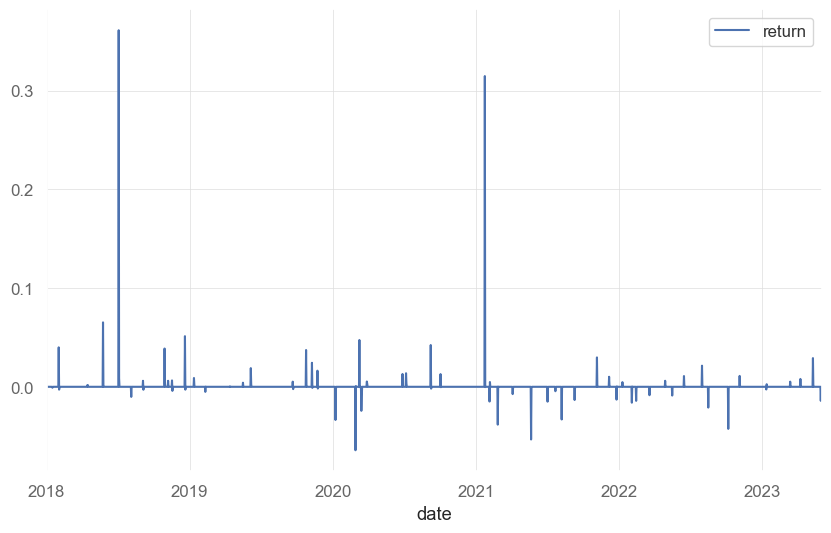

In [18]:
import quantstats as qs

# Get the strategy returns as a dictionary
returns_dict = backtest_results[0].analyzers.time_return.get_analysis()

# Convert the dictionary to a DataFrame
returns_df = (
        pd.DataFrame(
            list(returns_dict.items()),
            columns = ["date", "return"]
        )
        .set_index("date")
    )
returns_df.plot()

Since trading takes time, money and effort we need to make sure that our strategy is better than just being long on a position. So we will use this as a benchmark

In [19]:
#Compare to being long in the first ticker
bench_tickerA = df_forCointTest[cointPairs[1][0]].pct_change().dropna()
qs.reports.metrics(
        returns_df['return'],
        benchmark=bench_tickerA,
        mode="full"
    )

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2018-01-01  2018-01-01
End Period                 2023-06-01  2023-06-01
Risk-Free Rate             0.0%        0.0%
Time in Market             6.0%        100.0%

Cumulative Return          101.82%     -96.92%
CAGR﹪                     13.84%      -47.41%

Sharpe                     0.56        0.4
Prob. Sharpe Ratio         99.7%       88.07%
Smart Sharpe               0.56        0.4
Sortino                    2.33        0.76
Smart Sortino              2.31        0.76
Sortino/√2                 1.65        0.54
Smart Sortino/√2           1.63        0.53
Omega                      2.63        2.63

Max Drawdown               -20.2%      -99.84%
Longest DD Days            858         1970
Volatility (ann.)          18.38%      156.99%
R^2                        0.0         0.0
Information Ratio          -0.02       -0.02
Calmar                     0.69     

In [20]:
#Compare to being long in the second ticker
bench_tickerB = df_forCointTest[cointPairs[1][1]].pct_change().dropna()

qs.reports.metrics(
        returns_df['return'],
        benchmark=bench_tickerB,
        mode="full"
    )

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2018-01-01  2018-01-01
End Period                 2023-06-01  2023-06-01
Risk-Free Rate             0.0%        0.0%
Time in Market             6.0%        100.0%

Cumulative Return          101.82%     -39.64%
CAGR﹪                     13.84%      -8.9%

Sharpe                     0.56        0.41
Prob. Sharpe Ratio         99.7%       87.58%
Smart Sharpe               0.56        0.4
Sortino                    2.33        0.65
Smart Sortino              2.31        0.64
Sortino/√2                 1.65        0.46
Smart Sortino/√2           1.63        0.45
Omega                      2.63        2.63

Max Drawdown               -20.2%      -91.6%
Longest DD Days            858         1108
Volatility (ann.)          18.38%      96.51%
R^2                        0.0         0.0
Information Ratio          -0.02       -0.02
Calmar                     0.69        

We chose:
- CAGR
- Calmar Ratio
- Sortion Ratio

In [21]:
data = {'CAGR': [qs.stats.cagr(returns_df).item() , qs.stats.cagr(bench_tickerA) ,qs.stats.cagr(bench_tickerB)],
        'Calmar' : [qs.stats.calmar(returns_df).item(), qs.stats.calmar(bench_tickerA), qs.stats.calmar(bench_tickerB)],
        'Sortino' : [qs.stats.sortino(returns_df).item(), qs.stats.sortino(bench_tickerA), qs.stats.sortino(bench_tickerB)]}
index = ['Pairs Trading', 'Long Ticker_A', 'Long Ticker_B' ]

metrics_comparison = pd.DataFrame(index=index, data=data)
metrics_comparison.style.highlight_max(color = 'green', axis = 0)

,CAGR,Calmar,Sortino
Pairs Trading,0.138426,0.685258,2.332197
Long Ticker_A,-0.449029,-0.449736,0.798974
Long Ticker_B,-0.030541,-0.033342,0.720069


We chose three performance measures to compare the results of the pairs’ trading strategy with the performance of being long on the individual tickers - Ticker A and Ticker B:
- CAGR (Compound Annual Growth Rate): measures the average annual growth rate over a certain period. CAGR assumes that the investment grows at a constant rate every year, which helps to simplify the calculation and provides a single rate that represents the average annual growth over the entire investment period. In this case, being long on Ticker A and B individually resulted in a CAGR of -33.78% and -1.84% respectively, while the pairs trading strategy resulted in a CAGR of 9.36%. For this metric, the pairs trading strategy outperformed the strategy of being long on each individual ticker.
- Calmar ratio: measures the ratio of the average annual return of an investment to its maximum drawdown (largest peak-to-trough decline in value of an investment over a certain period). It is a risk adjusted metric since it takes into account the risk of an investment, measured by drawdowns it has experienced, with higher values of Calmar ratio translating into better risk-adjusted returns. In this case, being long on Ticker A and B individually resulted in a Calmar ratio of -33.83% and -2.01% respectively, while the pairs trading strategy resulted in a Calmar ratio of 46.35%. For this metric, the pairs trading strategy outperformed the strategy of being long on each individual ticker.
- Sortino ratio: measures the return of an investment in excess of the risk-free rate, divided by the downside volatility (standard deviation of negative returns). It is a risk-adjusted metric since it considers the downside risk, with higher values of the Sortino ratio translating into better risk-adjusted performances. In this case, being long on Ticker A and B individually resulted in a Sortino ratio of 79.81% and 72.57% respectively, while the pairs trading strategy resulted in a Sortino ratio of 233.22%. For this metric, the pairs trading strategy outperformed the strategy of being long on each individual ticker.

Compared to being long on each individual stock, the pairs trading strategy resulted in a higher CAGR, better risk-adjusted returns, and a better risk-adjusted performance considering only downside risk. 
The results seem to indicate that the pairs trading strategy that was created performs well in identifying opportunities in price movements’ deviations that can be exploited for a profit. 


## 5. Optimize and backtest your chosen strategy, leaving at least one full year out of the training data to test the strategy out of sample

We were unable to use the optstrategy() function because it took too long to run. Even with only _period_ and _devfactor_, we couldn't get the program to run to completion.

So we tried to mimic the optimization by running multiple backtests with different initial parameters, using loops. We then chose the best parameters to apply in the out-of-sample.

In [22]:
#BELOW CODE TAKES 510 MIN TO RUN SO WE USED LOOP AS AN ALTERNATIVE
# def runsOptStrategy(PL_results, df, tickers, start, end, cash=10_000, commperc=0.0, stake=10, plot=False, numfigs=1):

#     cerebro = bt.Cerebro()
    
#     ticker_A, ticker_B = tickers
#     data0 = bt.feeds.PandasData(dataname=extractTickerInfo(ticker_A, df, start, end))
    
#     cerebro.adddata(data0) 

#     data1 = bt.feeds.PandasData(dataname=extractTickerInfo(ticker_B, df, start, end))
#     cerebro.adddata(data1) 
    
    
    # cerebro.optstrategy(PairTradingStrategy,
    #                     period=[5,10,20],
    #                     devfactor=[1,1.5,2],
    #                     upper=[0.90,1,1.2],
    #                     lower=[-0.90,-1,-1.2],
    #                     stake=stake)  
    
#     cerebro.broker.setcash(cash)    
#     cerebro.broker.setcommission(commission=commperc)    

#     cerebro.addanalyzer(
#         bt.analyzers.Returns, _name="returns"
#     )
#     cerebro.addanalyzer(
#         bt.analyzers.TimeReturn, _name="time_return"
#     )
    
#     backtest_result =  cerebro.run()  
    
#     if plot:
#         cerebro.plot(iplot=False, numfigs=numfigs, volume=False, zdown=False)  

#     return backtest_result 

In [23]:
# PL_results = pd.DataFrame(columns=["results"])
# backtest_result = runsOptStrategy(PL_results, df, cointPairs[1], '2018-01-01', '2022-06-1', period=10, plot=False)

In [24]:
period=[5,10,20]
devfactor=[1,1.5,2]
upper=[0.9,1,1.1]
lower=[-0.9,-1,-1.1]

results_all = pd.DataFrame(columns=['period', 'devfactor', 'upper', 'lower', 'result'])

counter = 0
for p in period:
    for d in devfactor:
        for u in upper:
            for l in lower:
                counter += 1
                start_time = time.time()
                PL_results = pd.DataFrame(columns=["results"])
                backtest_result = runstrategy(PL_results, df, cointPairs[1], '2018-01-01', '2022-06-1', period=p, devfactor=d, upper=u, lower=l, plot=False)
                new_row = pd.DataFrame({'period': p, 'devfactor': d, 'upper': u, 'lower': l, 'result': PL_results['results'][0]}, index=[counter])
                results_all = pd.concat([results_all,new_row])
                total_time = time.time() - start_time

Starting Value:       10,000.00
Ending   Value:       45,336.63
Starting Value:       10,000.00
Ending   Value:       45,336.63
Starting Value:       10,000.00
Ending   Value:       45,336.63
Starting Value:       10,000.00
Ending   Value:       45,336.63
Starting Value:       10,000.00
Ending   Value:       45,336.63
Starting Value:       10,000.00
Ending   Value:       45,336.63
Starting Value:       10,000.00
Ending   Value:       45,336.63
Starting Value:       10,000.00
Ending   Value:       45,336.63
Starting Value:       10,000.00
Ending   Value:       45,336.63
Starting Value:       10,000.00
Ending   Value:       29,656.28
Starting Value:       10,000.00
Ending   Value:       29,656.28
Starting Value:       10,000.00
Ending   Value:       29,656.28
Starting Value:       10,000.00
Ending   Value:       29,656.28
Starting Value:       10,000.00
Ending   Value:       29,656.28
Starting Value:       10,000.00
Ending   Value:       29,656.28
Starting Value:       10,000.00
Ending  

In [25]:
sorted_df = results_all.sort_values('result', ascending=False)
max_row = sorted_df.head(1)

print(max_row)

  period devfactor  upper  lower       result
1      5         1    0.9   -0.9  45336.63301


In [26]:
sorted_df.head(5)

,period,devfactor,upper,lower,result
1,5,1,0.9,-0.9,45336.63301
3,5,1,0.9,-1.1,45336.63301
4,5,1,1.0,-0.9,45336.63301
5,5,1,1.0,-1.0,45336.63301
6,5,1,1.0,-1.1,45336.63301


## 6. What would have been the P/L of the strategy during the backtest and out of sample?

In [27]:
backtest = runstrategy(PL_results, df, cointPairs[1], '2018-01-01', '2022-06-1', period = 5, devfactor= 1, upper = 0.9, lower= -0.9, plot=False)
pnl = PL_results['results'][0] - 10_000
print(f'P/L during backtest: {pnl}')

Starting Value:       10,000.00
Ending   Value:       45,336.63
P/L during backtest: 35336.633009813726


In [28]:
outOfSample = runstrategy(PL_results, df, cointPairs[1], '2022-06-01', '2023-06-1', period = 5, devfactor= 1, upper = 0.9, lower= -0.9, plot=False)
pnl = PL_results['results'][0] - 10_000
print(f'P/L during out of sample: {pnl}')

Starting Value:       10,000.00
Ending   Value:       18,845.96
P/L during out of sample: 8845.963045105338
